In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import random
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import mediapipe as mp
import cv2
# from sklearn.model_selection import GridSearchCV

# 1.Make code reproducible

In [2]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)

In [3]:
set_seeds(42)

# 2.Load the data

In [4]:
df = pd.read_csv("hand_landmarks_data.csv")

In [5]:
print("Data shape:", df.shape)
df.head()

Data shape: (25675, 64)


,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


# 3.Data Exploration

## 3.1 Visualize sample

In [6]:
def plot_sample(sample_vis):
  for k in range(len(sample_vis)):
    row = sample_vis.iloc[k]

    # Extract x and y
    x = [row[f'x{i}'] for i in range(1,22)]
    y = [row[f'y{i}'] for i in range(1,22)]
    print(len(x))
    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, c='blue')

    # Optionally connect in order
    # for i in range(20):
    #     plt.plot([x[i], x[i+1]], [y[i], y[i+1]], color='gray')

    # Invert Y-axis to match image coordinates
    plt.gca().invert_yaxis()

    # plt.title(row["label"])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.axis("equal")  # Keep aspect ratio square
    plt.show()


21


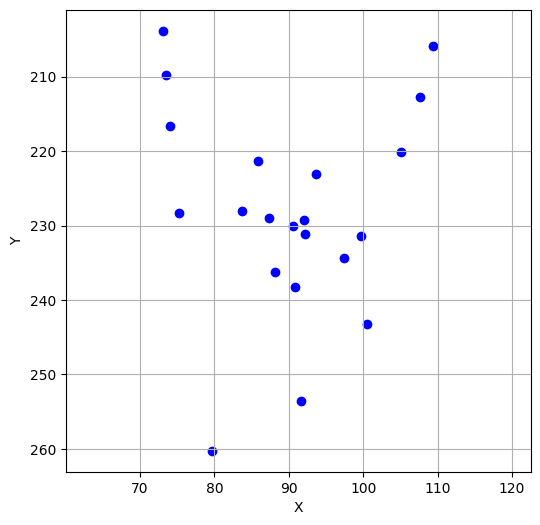

21


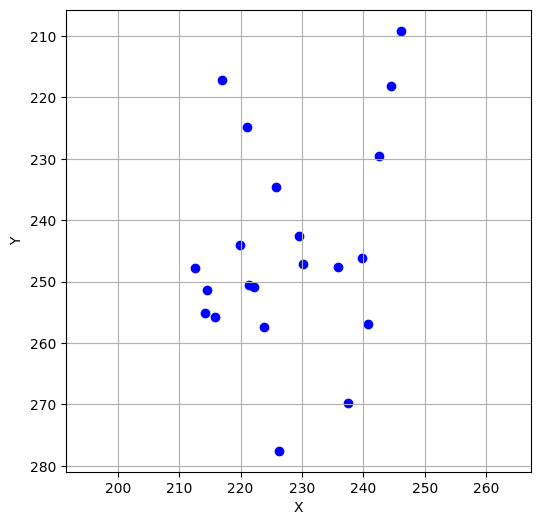

21


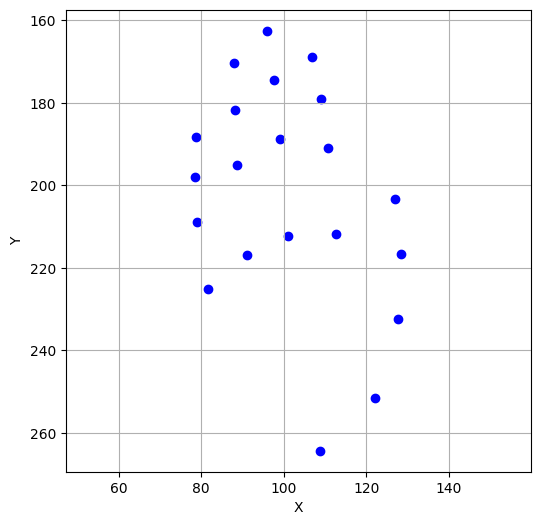

21


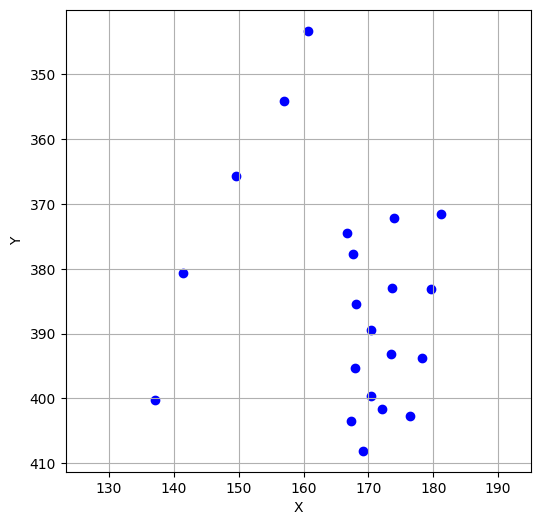

21


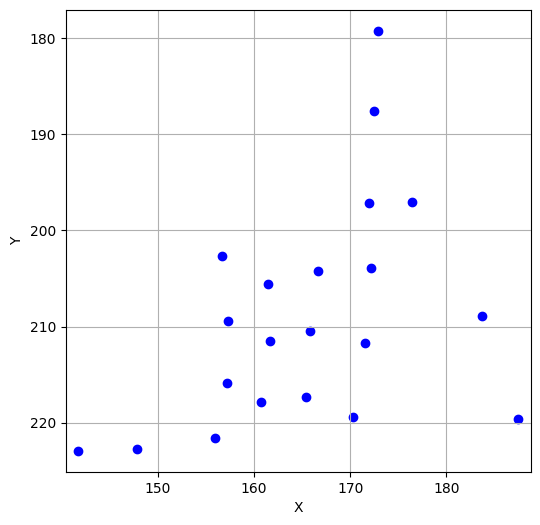

In [7]:
plot_sample(df.sample(5, random_state=42))

## 3.2 Checking Nulls

In [8]:
df.isna().sum().sum()

0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   z1      25675 non-null  float64
 3   x2      25675 non-null  float64
 4   y2      25675 non-null  float64
 5   z2      25675 non-null  float64
 6   x3      25675 non-null  float64
 7   y3      25675 non-null  float64
 8   z3      25675 non-null  float64
 9   x4      25675 non-null  float64
 10  y4      25675 non-null  float64
 11  z4      25675 non-null  float64
 12  x5      25675 non-null  float64
 13  y5      25675 non-null  float64
 14  z5      25675 non-null  float64
 15  x6      25675 non-null  float64
 16  y6      25675 non-null  float64
 17  z6      25675 non-null  float64
 18  x7      25675 non-null  float64
 19  y7      25675 non-null  float64
 20  z7      25675 non-null  float64
 21  x8      25675 non-null  float64
 22

## 3.3 Data balance

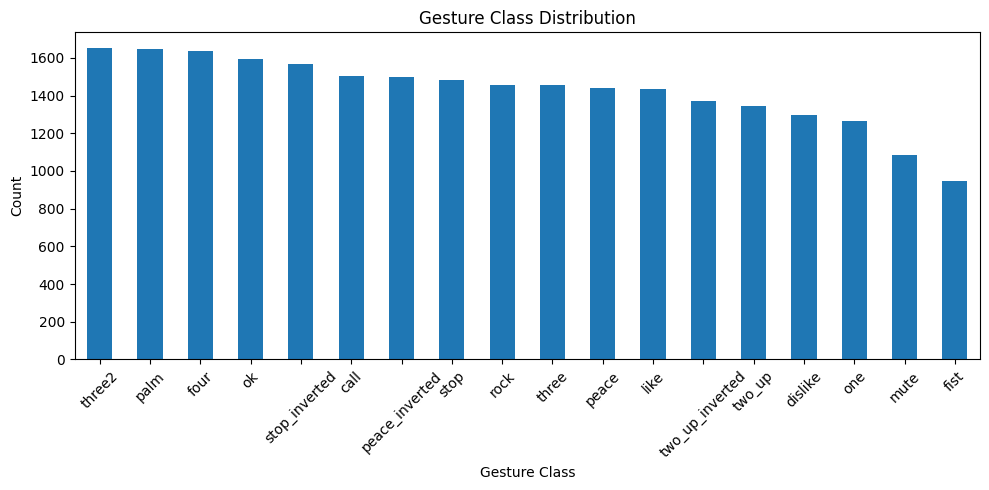

In [10]:
df['label'].value_counts().plot(kind='bar', figsize=(10,5), title='Gesture Class Distribution')
plt.xlabel("Gesture Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Data Almost balanced

## 3.4 Data Statistics Summary

In [11]:
df.describe()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
count,25675.000000,25675.000000,2.567500e+04,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,...,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000
mean,201.958632,260.158527,1.272461e-07,202.517395,252.115322,-0.009465,202.862981,240.645966,-0.015946,203.025267,...,-0.024129,201.792374,227.455597,-0.033751,201.811275,227.802576,-0.032208,201.874802,227.807287,-0.028828
std,90.500333,76.533210,2.737932e-07,84.770933,75.384691,0.010376,80.412089,74.721921,0.013973,79.647588,...,0.015658,94.046497,77.231210,0.020453,93.664595,78.441253,0.020877,93.547017,79.963438,0.021136
min,-36.050926,45.722923,-2.029986e-06,7.184681,51.256840,-0.096630,25.114323,45.489950,-0.155846,23.446341,...,-0.201897,0.198635,20.146784,-0.286821,3.278137,32.158108,-0.286470,-4.537216,23.226204,-0.262047
25%,124.110329,205.815950,-5.243216e-08,130.535929,197.999625,-0.015199,136.711035,187.018583,-0.023020,138.905817,...,-0.030728,126.828913,172.720392,-0.042726,126.887403,172.345467,-0.041957,126.356627,172.083794,-0.039220
50%,199.667847,255.181793,1.497277e-07,199.979530,247.113892,-0.008737,200.092758,235.776978,-0.014231,200.482040,...,-0.020969,197.579865,221.781479,-0.029942,197.591736,222.381149,-0.028510,197.453270,222.485229,-0.025269
75%,266.428482,304.991663,2.989988e-07,261.147457,296.850769,-0.002783,255.876354,284.925993,-0.007134,254.622768,...,-0.013661,268.103920,273.190765,-0.019987,267.745743,274.196884,-0.017971,267.324657,275.805222,-0.014294
max,633.556020,781.674469,1.876254e-06,606.232386,751.869416,0.076365,598.541348,719.365010,0.094131,607.999801,...,0.031774,632.923029,779.419948,0.078105,638.134761,760.854103,0.104580,641.788521,760.554894,0.118668


<Axes: >

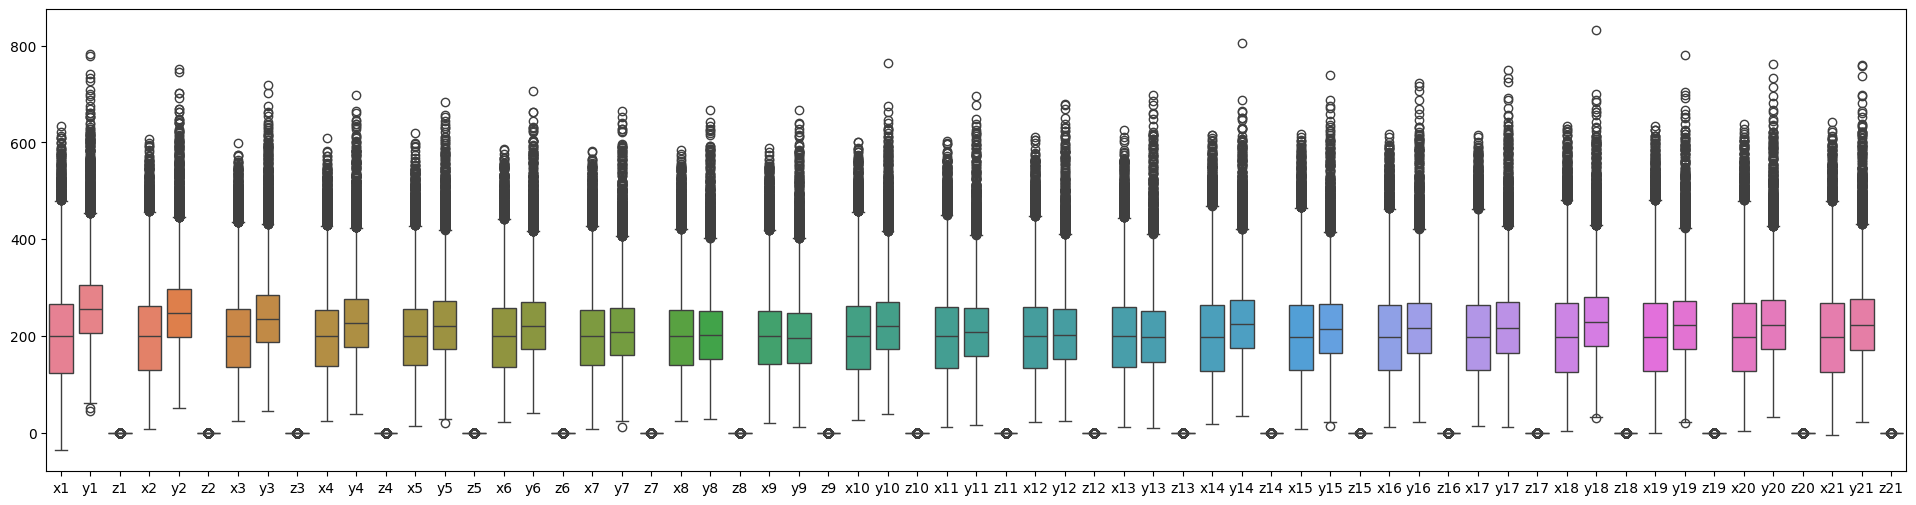

In [12]:
plt.figure(figsize=(24,6))
sns.boxplot(df.drop("label", axis=1))

# 4.Preprocessing

In [13]:
data = df.drop(columns=['label'])
labels = df['label']

## 4.1 Normalization

In [14]:
# Centering by wrist, and scaling by middle finger tip
def normalize_landmarks(row):
    coords = row.values.reshape(-1, 3)
    wrist = coords[0][:2]  # x, y of wrist
    mid_tip = coords[12][:2]  # x, y of middle finger tip
    scale = np.linalg.norm(mid_tip - wrist)
    coords[:, :2] = (coords[:, :2] - wrist) / (scale + 1e-6)
    return coords.flatten()

In [15]:
normalized_data = data.apply(normalize_landmarks, axis=1, result_type='expand')

In [16]:
normalized_data.columns = data.columns

In [17]:
normalized_data.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
0,0.0,0.0,-3.649205e-07,-0.169097,-0.328246,0.004224,-0.508248,-0.501843,0.005798,-0.846234,...,-0.013198,-1.266027,-0.058407,-0.020450,-1.533293,0.026072,-0.024577,-1.759842,0.074168,-0.026722
1,0.0,0.0,-2.345265e-07,-0.040618,-0.498120,-0.011102,0.191551,-0.982869,-0.021096,0.349889,...,-0.029042,1.397837,-0.121412,-0.038175,1.691695,-0.091952,-0.037336,1.966655,-0.086635,-0.036136
2,0.0,0.0,-2.417307e-07,0.172978,-0.420554,-0.000184,0.437913,-0.820949,-0.009687,0.621006,...,-0.041256,1.404372,0.187884,-0.044068,1.676609,0.247919,-0.040469,1.913833,0.270275,-0.038301
3,0.0,0.0,-1.233261e-07,-0.020056,-0.468103,-0.002824,0.070355,-0.911821,-0.008911,0.114792,...,-0.021804,1.280797,-0.094800,-0.027622,1.529073,-0.079763,-0.027863,1.738331,-0.086693,-0.027723
4,0.0,0.0,-1.622995e-07,-0.009611,-0.482677,-0.002884,0.111650,-1.075914,-0.008115,0.131602,...,-0.021623,1.327537,-0.331511,-0.025113,1.612488,-0.386821,-0.024087,1.849127,-0.464123,-0.023486


## 4.2 Cleaning

In [18]:
# normalized data after removing the wirst point
normalized_data = normalized_data.drop(["x1","y1","z1"], axis=1)

In [19]:
normalized_data.describe().round(1)

,x2,y2,z2,x3,y3,z3,x4,y4,z4,x5,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
count,25675.0,25675.0,25675.0,25675.0,25675.0,25675.0,25675.0,25675.0,25675.0,25675.0,...,25675.0,25675.0,25675.0,25675.0,25675.0,25675.0,25675.0,25675.0,25675.0,25675.0
mean,0.0,-0.1,-0.0,0.0,-0.3,-0.0,0.0,-0.5,-0.0,0.0,...,-0.0,0.0,-0.6,-0.0,0.0,-0.5,-0.0,0.0,-0.5,-0.0
std,0.2,0.2,0.0,0.4,0.4,0.0,0.5,0.6,0.0,0.5,...,0.0,0.6,0.5,0.0,0.6,0.6,0.0,0.6,0.6,0.0
min,-5.8,-1.4,-0.1,-13.7,-2.8,-0.2,-17.5,-3.9,-0.2,-18.0,...,-0.2,-28.5,-34.7,-0.3,-30.7,-40.2,-0.3,-32.4,-44.1,-0.3
25%,-0.2,-0.2,-0.0,-0.3,-0.5,-0.0,-0.3,-0.8,-0.0,-0.3,...,-0.0,-0.3,-0.6,-0.0,-0.2,-0.7,-0.0,-0.2,-0.8,-0.0
50%,0.1,-0.1,-0.0,0.1,-0.3,-0.0,0.0,-0.4,-0.0,0.0,...,-0.0,-0.0,-0.5,-0.0,-0.0,-0.5,-0.0,-0.0,-0.4,-0.0
75%,0.2,-0.1,-0.0,0.3,-0.2,-0.0,0.4,-0.3,-0.0,0.4,...,-0.0,0.3,-0.4,-0.0,0.3,-0.3,-0.0,0.2,-0.3,-0.0
max,1.2,8.9,0.1,1.9,18.8,0.1,2.5,30.2,0.1,3.1,...,0.0,2.9,1.2,0.1,3.6,1.4,0.1,3.9,1.7,0.1


In [20]:
# after normalization, Zs components have zero mean and std as shown above in data description.
normalized_data = normalized_data.drop([f"z{i}" for i in range(2,22)], axis=1)

## 4.3 Data Splitting

In [21]:
# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(normalized_data, labels, test_size=0.2, random_state=42)

# 5.Modeling

## 5.1 SVM

In [22]:
svm = SVC(C=100.0, kernel='rbf')
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

In [23]:
print(classification_report(y_test, svm_pred))

                 precision    recall  f1-score   support

           call       0.99      0.99      0.99       287
        dislike       0.99      1.00      0.99       260
           fist       0.99      0.99      0.99       209
           four       0.97      0.99      0.98       325
           like       1.00      1.00      1.00       304
           mute       0.96      0.97      0.96       195
             ok       0.99      0.99      0.99       340
            one       0.96      0.96      0.96       248
           palm       0.98      0.98      0.98       317
          peace       0.97      0.98      0.98       276
 peace_inverted       0.99      0.97      0.98       307
           rock       1.00      0.99      0.99       290
           stop       0.96      0.97      0.97       293
  stop_inverted       0.98      0.98      0.98       309
          three       0.99      0.96      0.98       298
         three2       0.99      1.00      1.00       331
         two_up       0.99    

## 5.2 Decision Tree

In [24]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)

In [25]:
print(classification_report(y_test, dtc_pred))

                 precision    recall  f1-score   support

           call       0.98      0.97      0.98       287
        dislike       1.00      0.99      0.99       260
           fist       0.99      0.98      0.98       209
           four       0.93      0.93      0.93       325
           like       0.99      0.98      0.99       304
           mute       0.88      0.89      0.88       195
             ok       0.98      0.97      0.97       340
            one       0.88      0.91      0.89       248
           palm       0.93      0.94      0.94       317
          peace       0.90      0.89      0.90       276
 peace_inverted       0.90      0.93      0.92       307
           rock       0.99      0.97      0.98       290
           stop       0.88      0.88      0.88       293
  stop_inverted       0.91      0.91      0.91       309
          three       0.96      0.96      0.96       298
         three2       0.98      0.98      0.98       331
         two_up       0.91    

## 5.3 Random Forest

In [26]:
rnf = RandomForestClassifier(n_estimators=150, min_samples_split=2, max_depth=None)
rnf.fit(X_train, y_train)
rnf_pred = rnf.predict(X_test)

In [27]:
print(classification_report(y_test, rnf_pred))

                 precision    recall  f1-score   support

           call       0.99      0.99      0.99       287
        dislike       1.00      0.99      1.00       260
           fist       0.99      0.99      0.99       209
           four       0.96      0.97      0.97       325
           like       1.00      0.99      1.00       304
           mute       0.94      0.96      0.95       195
             ok       0.98      0.99      0.99       340
            one       0.96      0.96      0.96       248
           palm       0.98      0.98      0.98       317
          peace       0.94      0.95      0.95       276
 peace_inverted       0.97      0.96      0.97       307
           rock       1.00      0.98      0.99       290
           stop       0.93      0.96      0.94       293
  stop_inverted       0.95      0.95      0.95       309
          three       0.99      0.95      0.97       298
         three2       0.98      1.00      0.99       331
         two_up       0.96    

## 5.4 XGBoost

In [28]:
lb = LabelEncoder()
encoded_label = lb.fit_transform(y_train)

In [29]:
xgb = XGBClassifier()
xgb.fit(X_train, encoded_label)
xgb_pred = xgb.predict(X_test)

In [30]:
print(classification_report(lb.fit_transform(y_test), xgb_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       287
           1       1.00      0.99      1.00       260
           2       1.00      0.99      0.99       209
           3       0.97      0.98      0.97       325
           4       1.00      1.00      1.00       304
           5       0.95      0.96      0.95       195
           6       0.99      0.99      0.99       340
           7       0.95      0.95      0.95       248
           8       0.99      0.98      0.99       317
           9       0.95      0.97      0.96       276
          10       0.97      0.96      0.97       307
          11       0.99      0.99      0.99       290
          12       0.95      0.96      0.95       293
          13       0.97      0.96      0.96       309
          14       0.98      0.96      0.97       298
          15       0.99      1.00      0.99       331
          16       0.98      0.98      0.98       267
          17       0.97    

The best model is XGBoost.

# 6. Save pkls

In [49]:
joblib.dump(lb, 'chekpoints/label_encoder.pkl')

['chekpoints/label_encoder.pkl']

In [50]:
joblib.dump(xgb, 'chekpoints/xgb_model.pkl')

['chekpoints/xgb_model.pkl']

In [59]:
joblib.dump(rnf, 'chekpoints/rnf_model.pkl')

['chekpoints/rnf_model.pkl']

In [46]:
# # Training normalizer
# def preprocess_landmarks(landmarks):
#     coords = np.array(landmarks).reshape(-1, 3)
#     wrist = coords[0][:2]
#     mid_tip = coords[12][:2]
#     scale = np.linalg.norm(mid_tip - wrist)
#     coords[:, :2] = (coords[:, :2] - wrist) / (scale + 1e-6)
#     return coords.flatten()

In [45]:
# # MediaPipe setup
# mp_hands = mp.solutions.hands
# hands = mp_hands.Hands(static_image_mode=False,
#                        max_num_hands=1,
#                        min_detection_confidence=0.5)
# mp_drawing = mp.solutions.drawing_utils


# # Open webcam
# cap = cv2.VideoCapture(0)

# try:
#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             break

#         # Flip and convert to RGB
#         image = cv2.flip(frame, 1)
#         image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         result = hands.process(image_rgb)

#         if result.multi_hand_landmarks:
#             for hand_landmarks in result.multi_hand_landmarks:
#                 landmarks = []
#                 for lm in hand_landmarks.landmark:
#                     h, w, _ = image.shape
#                     landmarks.append([lm.x * w, lm.y * h, lm.z])

#                 processed = preprocess_landmarks(landmarks)
#                 # Remove Zs components
#                 processed = processed.reshape(-1,3)[:,:2].flatten()
#                 # Remove wrist point
#                 processed = processed[2:].reshape(1, -1)
#                 prediction = rnf.predict(processed)[0]

#                 # Draw landmarks & prediction
#                 mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
#                 # prediction = lb.inverse_transform(prediction)
#                 cv2.putText(image, f'Gesture: {prediction}', (10, 50),
#                             cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

#         cv2.imshow('Hand Gesture Prediction', image)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
# finally:
#     cap.release()
#     cv2.destroyAllWindows()
